In [3]:
print("strawberry")

# loss function and metrics
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices
from trustworthai.utils.losses_and_metrics.dice_loss_metric import DiceLossMetric, SsnDiceMeanMetricWrapper

# predefined training dataset
from trustworthai.utils.data_preprep.dataset_pipelines import load_data
from torch.utils.data import ConcatDataset

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.fitters.p_unet_fitter import PUNetLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# model
from trustworthai.journal_run.model_load.load_ssn import load_ssn
from trustworthai.journal_run.model_load.load_punet import load_p_unet
from trustworthai.journal_run.model_load.load_deterministic import load_deterministic
from trustworthai.models.stochastic_wrappers.ssn.LowRankMVCustom import LowRankMultivariateNormalCustom
from trustworthai.models.stochastic_wrappers.ssn.ReshapedDistribution import ReshapedDistribution

# optimizer and lr scheduler
import torch


import numpy as np
import scipy.stats
from trustworthai.utils.plotting.saving_plots import save, imsave
from trustworthai.utils.print_and_write_func import print_and_write

# misc
import argparse
import os
import shutil
import shlex
from collections import defaultdict
from tqdm import tqdm
import sys
from natsort import natsorted

import pandas as pd
from trustworthai.analysis.connected_components.connected_comps_2d import conn_comp_2d_analysis
from trustworthai.analysis.evaluation_metrics.challenge_metrics import getAVD, getDSC, getHausdorff, getLesionDetection, do_challenge_metrics
from sklearn import metrics
import math

import torch
import matplotlib.pyplot as plt
from trustworthai.utils.plotting.saving_plots import save
from trustworthai.utils.print_and_write_func import print_and_write
from trustworthai.analysis.calibration.helper_funcs import *
from tqdm import tqdm
from trustworthai.utils.logits_to_preds import normalize_samples

print("banana")


strawberry
running on local machine!
banana


In [4]:
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever

In [5]:
import matplotlib.pyplot as plt
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples

In [6]:
%load_ext autoreload

In [7]:
import seaborn as sns

In [49]:
class ARGS():
    def __init__(self):
    
        # folder arguments
        self.ckpt_dir = '/media/benp/NVMEspare/model_dump/eval_pl_outdump/'
        self.model_name = "standard_model_duplicate"
        self.model_ckpts_folder = "/media/benp/NVMEspare/model_data/journal_models/" # "/home/s2208943/ipdis/results/cross_validated_models/"
        self.repo_dir = "/home/benp/Documents/PhD_projects/WMH_UQ_assessment"
        self.result_dir = "trustworthai/journal_run/evaluation/results/initial_hparam_tuning/out_domain_results"
        
        # data generation arguments
        self.dataset = 'chal'
        self.seed = 3407
        self.test_split = 0.15
        self.val_split = 0.15
        self.empty_slice_retention = 0.1
        
        # general arguments for the loss function
        self.loss_name = 'dice+xent'#'dicev2'#'dice+xent'
        self.dice_factor = 1#5
        self.xent_factor = 1#0.01
        self.xent_weight = 'none'
        self.xent_reweighting=None,
        self.dice_empty_slice_weight = 0.5
        self.tversky_beta = 0.7
        self.reduction = 'mean'#'mean_sum'
        
        # training paradigm arguments
        self.lr = 2e-4
        self.dropout_p = 0.0
        self.max_epochs = 100
        self.early_stop_patience = 15
        self.batch_size = 8#32
        self.cross_validate = False
        self.cv_split = 0
        self.cv_test_fold_smooth = 1
        self.weight_decay = 0.0001
        self.overwrite = "false"
        self.no_test_fold = 'false'

In [50]:
args = ARGS()
args.overwrite = True if args.overwrite.lower() == "true" else False
args.cross_validate = True

model_ckpts_folder = args.model_ckpts_folder

In [10]:
def load_best_checkpoint(model, loss, model_ckpt_folder, punet=False):
    # this is ultimately going to need to be passed a model wrapper when I implement P-Unet....
    
    # the path to the best checkpoint is stored as a single line in a txt file along with each model
    with open(os.path.join(model_ckpt_folder, "best_ckpt.txt"), "r") as f:
        ckpt_file = os.path.join(model_ckpt_folder, f.readlines()[0][:-1].split("/")[-1])
    
    if punet:
        return PUNetLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)
    return StandardLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)

In [13]:


def write_model_metric_results(results_file, data):
    for key in data.keys():
        print_and_write(results_file, key, newline=1)
        print_and_write(results_file, data[key])
        
        # ignore any bad images, that will cause values of 0 to appear
        values = data[key]
        ignores = (values < 0.001) | torch.isnan(values)
        if key == 'avd':
            ignores = ignores | (values == 100)
        values = values[~ignores]
        
        print_and_write(results_file, f"{key} mean", newline=1)
        print_and_write(results_file, values.mean())
        
        print_and_write(results_file, f"{key} standard error", newline=1)
        print_and_write(results_file, scipy.stats.sem(values))
        
        
def fast_dice(pred, target):
    p1 = (pred == 1)
    t1 = (target == 1)
    intersection = (pred == 1) & (target == 1)
    numerator = 2 * intersection.sum()
    denominator = p1.sum() + t1.sum()
    return (numerator/(denominator + 1e-30)).item()

def fast_avd(pred, target):
    p1 = pred.sum()
    t1 = target.sum()
    
    return ((p1 - t1).abs() / t1) * 100

def fast_vd(pred, target):
    p1 = pred.sum()
    t1 = target.sum()
    
    return ((p1 - t1) / t1) * 100


def fast_dice(pred, target):
    p1 = (pred == 1)
    t1 = (target == 1)
    intersection = (pred == 1) & (target == 1)
    numerator = 2 * intersection.sum()
    denominator = p1.sum() + t1.sum()
    return (numerator/(denominator + 1e-30)).item()

def fast_avd(pred, target):
    p1 = pred.sum()
    t1 = target.sum()
    
    return ((p1 - t1).abs() / t1) * 100

def fast_vd(pred, target):
    p1 = pred.sum()
    t1 = target.sum()
    
    return ((p1 - t1) / t1) * 100

In [14]:
def GT_volumes(ys3d):
    volumes = []
    for y in ys3d:
        volumes.append(y.sum())
    return torch.Tensor(volumes)

In [15]:
# get the 2d axial slice dataloaders
data_dict = load_data(
    dataset=args.dataset, 
    test_proportion=args.test_split, 
    validation_proportion=args.val_split,
    seed=args.seed,
    empty_proportion_retained=args.empty_slice_retention,
    batch_size=args.batch_size,
    dataloader2d_only=False,
    cross_validate=args.cross_validate,
    cv_split=args.cv_split,
    cv_test_fold_smooth=args.cv_test_fold_smooth,
    merge_val_test=args.no_test_fold
)


39 9 12


In [16]:
train_imgs = data_dict['train_datset3d']
val_imgs = data_dict['val_dataset3d']
test_imgs = data_dict['test_dataset3d']

In [21]:
eval_ds = train_imgs

In [27]:
xs3d_test = []
ys3d_test = []

for i, data in enumerate(eval_ds):
    ys3d_test.append(data[1].squeeze())
    xs3d_test.append(data[0])

In [22]:
# load the model and loss function
model_loader = load_deterministic
model_raw, loss, val_loss = model_loader(args)

In [23]:
# load the checkpoint under consideration
model_dir = os.path.join(args.model_ckpts_folder, args.model_name) 
print("model dir: ", model_dir)
model = load_best_checkpoint(model_raw, loss, model_dir)

model dir:  /media/benp/NVMEspare/model_data/journal_models/standard_model_duplicate


In [24]:
val_imgs[0][0].shape

torch.Size([3, 48, 224, 160])

In [25]:

means = []
temp = 1
batch_image = False

model.eval()
for i, data in enumerate(tqdm(eval_ds, position=0, leave=True)):
    x = data[0]
    with torch.no_grad():
        if batch_image:
            mean = model(x.swapaxes(0,1).cuda()).cpu()
        else:
            mean = []
            for islice in range(x.shape[1]):
                mean.append(model(x[:,islice].unsqueeze(0).cuda()).cpu())
            mean = torch.cat(mean)
        means.append(mean / temp)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:18<00:00,  2.16it/s]


In [26]:
preds = [torch.softmax(m.cuda(), dim=1).cpu() for m in means]

In [28]:
chal_results = per_model_chal_stats(preds, ys3d_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:27<00:00,  1.40it/s]


In [29]:
chal_results

{'dice': tensor([0.7807, 0.6293, 0.7816, 0.7602, 0.6979, 0.8614, 0.7445, 0.8433, 0.3754,
         0.7563, 0.6412, 0.8227, 0.8693, 0.8704, 0.7397, 0.2500, 0.8027, 0.8343,
         0.7600, 0.4264, 0.5550, 0.3088, 0.1917, 0.7251, 0.7937, 0.7365, 0.6650,
         0.4957, 0.3075, 0.4415, 0.6483, 0.7261, 0.4708, 0.6679, 0.7425, 0.6794,
         0.6627, 0.5768, 0.4961]),
 'hd95': tensor([ 5.6656, 16.1725,  2.8284,  3.1623,  4.8990,  3.1623,  7.8740,  7.2111,
         26.1178,  4.4721, 11.0179,  3.1623,  8.0623,  3.7417, 13.0384, 23.9895,
          5.7446,  4.8990, 11.7345, 23.4478, 21.2132, 23.9374, 21.5639, 10.6301,
          9.4868, 10.4881,  4.1231, 13.9284, 44.7207, 17.0294,  8.1240,  2.2361,
         19.1937, 16.5045,  3.1623, 12.7279,  6.5722,  7.1131,  7.6713]),
 'avd': tensor([1.7662e+01, 3.3192e+01, 2.6671e+01, 2.5422e+01, 3.7279e+01, 1.9908e+01,
         2.1979e+01, 1.8308e+00, 3.3596e+01, 2.8845e+01, 6.9982e+00, 1.9468e+01,
         1.8256e-01, 4.4582e+00, 2.4474e+01, 5.3438e+02, 1

In [34]:
import pandas as pd

In [36]:
df = pd.DataFrame(chal_results)
df['model_name'] = [args.model_name for _ in range(len(df))]

In [55]:
df

,dice,hd95,avd,recall,f1,model_name
0,0.780682,5.665625,17.661816,0.537500,0.600025,standard_model_duplicate
1,0.629320,16.172501,33.191746,0.320000,0.375587,standard_model_duplicate
2,0.781582,2.828427,26.671215,0.365079,0.457091,standard_model_duplicate
3,0.760164,3.162278,25.422283,0.406250,0.498235,standard_model_duplicate
4,0.697896,4.898980,37.279411,0.375000,0.493369,standard_model_duplicate
5,0.861426,3.162278,19.908041,0.426829,0.498812,standard_model_duplicate
6,0.744507,7.874008,21.979115,0.426829,0.438369,standard_model_duplicate
7,0.843251,7.211102,1.830831,0.718750,0.559208,standard_model_duplicate
8,0.375394,26.117807,33.595802,0.326087,0.344828,standard_model_duplicate
9,0.756294,4.472136,28.845362,0.300000,0.384401,standard_model_duplicate


In [85]:
overall_stats = {"model_name":[args.model_name]}

for key, value in chal_results.items():
    mean = value.mean()
    std = value.std(correction=1) # https://en.wikipedia.org/wiki/Bessel%27s_correction#Source_of_bias in this case we know the true mean..?
    # I want the standard deviation across this dataset, and I have a full sample, so I should use correction = 0? Or are we saying we have a limited sample of data from
    # an infinite distribution, and we want to know the model performance on that distribution, so correction = 1. Hmm this is a bit of a headache.
    conf_int = 1.96 * std / np.sqrt(len(value))

    lower_bound = mean - conf_int
    upper_bound = mean + conf_int
    
    overall_stats[f"{key}_mean"] = [mean.item()]
    overall_stats[f"{key}_95%conf"] = [conf_int.item()]

    print(f"95% confidence interval for {key}: [{lower_bound:.3f}, {upper_bound:.3f}], conf_int={conf_int:.3f}")

95% confidence interval for dice: [0.587, 0.702], conf_int=0.057
95% confidence interval for hd95: [8.776, 14.343], conf_int=2.784
95% confidence interval for avd: [22.389, 110.025], conf_int=43.818
95% confidence interval for recall: [0.509, 0.607], conf_int=0.049
95% confidence interval for f1: [0.433, 0.530], conf_int=0.048


In [78]:
overall_stats

,model_name,dice_mean,dice_95%conf,hd95_mean,hd95_95%conf,avd_mean,avd_95%conf,recall_mean,recall_95%conf,f1_mean,f1_95%conf
0,standard_model_duplicate,0.644573,0.057391,11.559727,2.783567,66.206985,43.81757,0.558044,0.048852,0.481239,0.048309


In [79]:
overall_stats = pd.DataFrame(overall_stats)

In [80]:
model_result_dir = os.path.join(args.repo_dir, args.result_dir, args.model_name)

In [84]:
df.to_csv(model_result_dir + "_individual_stats.csv")
overall_stats.to_csv(model_result_dir + "_overall_stats.csv")

In [82]:
model_result_dir

'/home/benp/Documents/PhD_projects/WMH_UQ_assessment/trustworthai/journal_run/evaluation/results/initial_hparam_tuning/out_domain_results/standard_model_duplicate'

In [ ]:
model_result_dir

In [39]:
import scipy.stats

In [45]:
1.96 * scipy.stats.sem(data['dice'], ddof=1)

0.057390846351506014

In [32]:
################################### The actual run script ##################################
################################### Nice ###################################################


# The only run script that I need for a deterministic model is to find the challenge metrics etc for the model predictions. Nice.


def run_eval(args):
    
    name = args.name
    splits = args.splits
    stride = args.stride
    temp = 1
    num_samples = 10
        
    
    name_to_method_map = {
        "softmax_ent":[generate_means_and_samples_CategoricalSoftmax],
        "mc_drop":[generate_means_and_samples_MC_Dropout],
        "evidential":[generate_means_and_samples_Evidential],
        "ensemble":[generate_means_and_samples_Ensemble],
        "SSN_ensemble":[generate_means_and_samples_SSN_Ens],
        "SSN_ensemble_mean":[generate_means_and_samples_SSN_Ens_Mean],
        "SSN":[generate_means_and_samples_SSN],
        "SSN_Ind":[generate_means_and_samples_SSN],
        "P-Unet":[generate_means_and_samples_PUNet],
    }
    
    method_func = name_to_method_map[name][0]
    if name == "SSN_Ind":
        means, samples, test_datasets = method_func(splits=splits, dataset_stride=stride, temp=temp, num_samples=num_samples, independent=True)
    elif name == "softmax_ent":
        means, samples, test_datasets = method_func(splits=splits, dataset_stride=stride, temp=temp, num_samples=num_samples, loss_name=args.determin_loss_name)
    else:
        means, samples, test_datasets = method_func(splits=splits, dataset_stride=stride, temp=temp, num_samples=num_samples)
        
    if "softmax" in name:
        name += "_" + args.determin_loss_name

    save_folder = f"/home/s2208943/ipdis/UQ_WMH_methods/trustworthai/run/results/{name}/"
    results_file = save_folder + "text_results.txt"

    try:
        os.mkdir(save_folder)
        os.mkdir(save_folder + "/images")
    except:
        pass

    with open(results_file, "w") as f:
        print_and_write(results_file, "begin results")
       
    
    # GET THE UMAPS
    # softmax entropy
    if "softmax" in name:
        ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=True) for scan_index in range(len(means))]

    # evidential
    elif "evidential" in name:
        ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=False) for scan_index in range(len(means))]

    else:
        ent_maps = [entropy_map_from_samples(samples[scan_index]) for scan_index in range(len(means))]
      
    
    # collect input data
    xs3d_test = []
    ys3d_test = []

    for i, data in enumerate(test_datasets):
        if i % stride == 0:
            ys3d_test.append(data[1].squeeze())
            xs3d_test.append(data[0])
            
    # do some plotting
    # plot_example(save_folder, test_datasets, means, ent_maps, 87, 15, stride)
    # plot_example(save_folder, test_datasets, means, ent_maps, 103, 35,stride)
    # plot_example(save_folder, test_datasets, means, ent_maps, 52, 35, stride)
    # plot_example(save_folder, test_datasets, means, ent_maps, 1, 25, stride)
    plot_example(save_folder, test_datasets, means, ent_maps, 0, 25, stride)
    # plot_example(save_folder, test_datasets, means, ent_maps, 57, 25, stride)
    # plot_example(save_folder, test_datasets, means, ent_maps, 60, 30, stride)
    # plot_example(save_folder, test_datasets, means, ent_maps, 70, 25, stride)
    
    plt.style.use('fivethirtyeight')
    
    # energy distance score
    geds_reordered = iou_GED(means, ys3d_test, samples, reorder=True)
    
    print_and_write(results_file, "reordered GED values", newline=1)
    print_and_write(results_file, geds_reordered)

    print_and_write(results_file, "reordered GED mean", newline=1)
    print_and_write(results_file, geds_reordered.mean())

    print_and_write(results_file, "reordered GED standard error", newline=1)
    print_and_write(results_file, scipy.stats.sem(geds_reordered))
    
    # sample diversity analysis
    standard_sample_dices = metric_across_samples_analysis(results_file, ys3d_test, samples, reorder=False, metric="dice")
    reorder_sample_dices = metric_across_samples_analysis(results_file, ys3d_test, samples, reorder=True, metric="dice")
    standard_sample_avds = metric_across_samples_analysis(results_file, ys3d_test, samples, reorder=False, metric="avd")
    reorder_sample_avds = metric_across_samples_analysis(results_file, ys3d_test, samples, reorder=True, metric="avd")
    
    # standard_sample_VDS = vd_per_sample(ys3d_test, samples, reorder=False)
    reorder_sample_VDS = vd_per_sample(ys3d_test, samples, reorder=True)
    gt_vols = GT_volumes(ys3d_test)
    sample_diversity_plot_by_volume(save_folder, reorder_sample_VDS*0.003, gt_vols, "Volume Difference (%)")
    
    # bras and sueo scores
    uncertainty_thresholds = torch.arange(0, 0.7, 0.01)

    filtered_dices = []
    filtered_tns = []
    filtered_tps = []

    for i in tqdm(range(len(means)), position=0, leave=True):
        mean = means[i].cuda().argmax(dim=1)
        ent_map = ent_maps[i].cuda()
        y = ys3d_test[i].cuda()
        mask = xs3d_test[i][1].cuda()

        ind_filtered_dices = []
        ind_filtered_tns = []
        ind_filtered_tps = []

        if mean.sum() == 0:
            continue

        for t in uncertainty_thresholds:
            ind_filtered_dices.append(filtered_dice(mean, ent_map, y, t))
            ind_filtered_tns.append(filtered_tns_score(mask, mean, ent_map, y, t))
            ind_filtered_tps.append(filtered_tps_score(mean, ent_map, y, t))

        filtered_dices.append(ind_filtered_dices)
        filtered_tns.append(ind_filtered_tns)
        filtered_tps.append(ind_filtered_tps)


    # we need to calculate the area under the curve of the dice, so that will be mean dice per threshold?
    filtered_dices = torch.stack([torch.Tensor(v) for v in filtered_dices], dim=0)
    filtered_tns = torch.stack([torch.Tensor(v) for v in filtered_tns], dim=0)
    filtered_tps = torch.stack([torch.Tensor(v) for v in filtered_tps], dim=0)
    
    fdice_curve = filtered_dices.mean(dim=0)
    tn_curve = filtered_tns.mean(dim=0)
    tp_curve = filtered_tps.mean(dim=0)
    max_ent = math.log(0.5)
    bras_score = (1/3) * (
        metrics.auc(uncertainty_thresholds/max_ent, fdice_curve)
         + (1 - metrics.auc(uncertainty_thresholds/max_ent, tn_curve))
         + (1 - metrics.auc(uncertainty_thresholds/max_ent, tp_curve))
    )
    print_and_write(results_file, "bras score", newline=1)
    print_and_write(results_file, bras_score)
    
    sUEOs = []
    for i in tqdm(range(len(means)), position=0, leave=True):
        pred = means[i].argmax(dim=1).cuda()
        target = ys3d_test[i].cuda()
        ent = ent_maps[i].cuda()

        if pred.sum() == 0:
            continue

        sUEOs.append(sUEO(pred, ent, target))

    sUEOs = torch.Tensor(sUEOs)
    print_and_write(results_file, "sUEO mean", newline=1)
    print_and_write(results_file, sUEOs.mean())

    print_and_write(results_file, "sUEO standard error", newline=1)
    print_and_write(results_file, scipy.stats.sem(sUEOs))
    
    UEO_per_threshold_analysis(save_folder, results_file, uncertainty_thresholds, ys3d_test, ent_maps, means, max_ent)
    
    if "softmax" in name:
        # for softmax entropy
        calibration_over_samples(save_folder, results_file, means, samples, ys3d_test, do_normalize=True, mode="mean_only")

    # evidential
    elif "evidential" in name:
        # For evidential
        calibration_over_samples(save_folder, results_file, means, samples, ys3d_test, do_normalize=False, mode="mean_only")

    else:
        # for other models
        calibration_over_samples(save_folder, results_file, means, samples, ys3d_test, do_normalize=True, mode="mean_conf")
        
        
    # collect the challenge data
    challenge_data = per_model_chal_stats(means, ys3d_test)
    write_model_metric_results(results_file, challenge_data)
    
    # the more expensive code goes at the end
    # 2D slice coverage
    uncertainty_thresholds = torch.arange(0, 0.7, 0.01)
    conn_comp_2d_analysis(save_folder, results_file, uncertainty_thresholds, ys3d=ys3d_test, means3d=means, ind_ent_maps=ent_maps)
    
    print("DONE!")

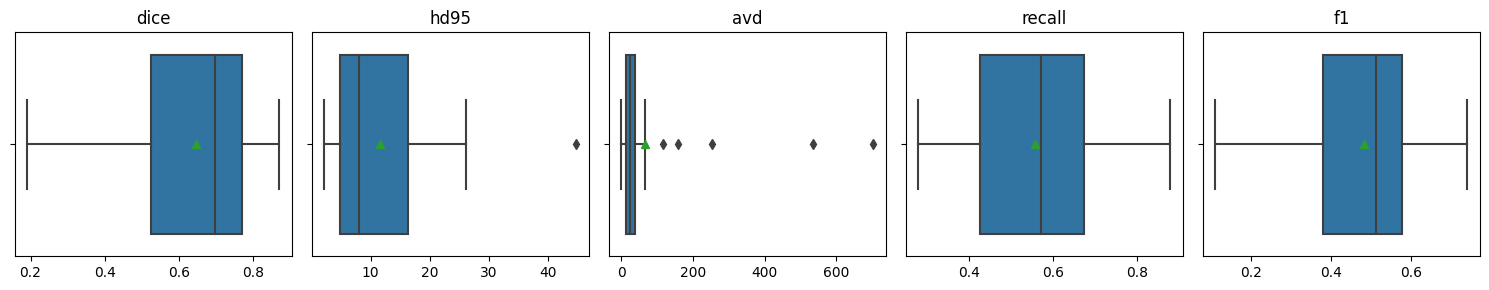

In [30]:
data = chal_results
# Create a figure with subfigures
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

# Iterate over the data dictionary and create boxplots for each key
for i, (key, value) in enumerate(data.items()):
    sns.boxplot(
        x=value.tolist(),
        ax=axes[i],
        showmeans=True,
    )

    axes[i].set_title(key)

# Tighten the layout
plt.tight_layout()

# Show the figure
plt.show()